# MetaCLIP Data Curation

In this notebook, we plot the results of using [MetaCLIP](https://arxiv.org/pdf/2309.16671) data curation (reinterpreted as data balancing) on the ImageNet-Captions dataset. Please see `../notebooks/create_metaclip_dataset.ipynb` to see how the quantities of interest are computed.

In [7]:
import numpy as np
import os
import json

import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib as mpl

mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['xtick.labelsize'] = 15
mpl.rcParams['ytick.labelsize'] = 15
mpl.rcParams["axes.labelsize"] = 15
mpl.rcParams['legend.fontsize'] = 20
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

## Comparison of Observed and Desired Marginal Distribution

We load the `observed_entry_marginal.npy` and `rebalanced_entry_marginal.npy` objects to show the difference in marginal distributions over entries (a.k.a. keywords), which are computed in `../notebooks/create_metaclip_dataset.ipynb`.

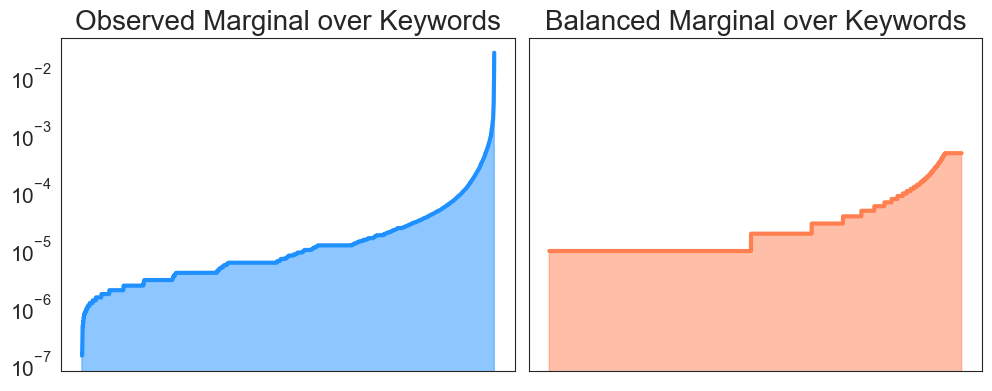

In [5]:
entry_marginal = np.load("../data/observed_entry_marginal.npy")
py = np.load("../data/rebalanced_entry_marginal.npy")

sns.set_style("white")
fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

x = np.arange(len(entry_marginal))
ax[0].plot(x, np.sort(entry_marginal), color="dodgerblue", linewidth=3)
ax[1].plot(x, np.sort(py), color="coral", linewidth=3)

ax[0].set_title(r"Observed Marginal over Keywords", fontsize=20)
ax[1].set_title(r"Balanced Marginal over Keywords", fontsize=20)
ax[0].set_yscale("log")
ax[1].set_yscale("log")

ax[0].fill_between(x, 0.0, y2=np.sort(entry_marginal), color="dodgerblue", alpha=0.5)
ax[1].fill_between(x, 0.0, y2=np.sort(py), color="coral", alpha=0.5)

ax[0].set_xticks([])
ax[1].set_xticks([])

fig.tight_layout(pad=1.0)
plt.show()

## Zero-Shot Performance of MetaCLIP Model

Next, we compare the zero-shot evaluation performance of the MetaCLIP-based model to the original one. In both cases, we use CLIP embeddings.

In [9]:
OUTPUT_DIR = "../results"

In [10]:
colors = ["tab:blue", "tab:red"]
model_names = [r"CLIP",  r"MetaCLIP"]
markers = ["s", "o", "^"]

def load_result(model_name, dataset, ckpt):
    root = os.path.join(OUTPUT_DIR, model_name)
    with open(os.path.join(root, f"{dataset}_{ckpt}.json")) as f:
        result = json.load(f)
    return result

def create_ax(ax, batch_str, dataset, metric="mean_per_class_recall"):
    checkpoints = np.arange(500, 5001, 500)
    for i, model_type in enumerate(["clip_separate", "metaclip"]):
        model_name =  f"{model_type}{batch_str}"
        perf = np.array([load_result(model_name, dataset, ckpt)['metrics'][metric] for ckpt in checkpoints])
        perf = np.maximum.accumulate(perf)
        ax.plot(checkpoints, perf, color=colors[i], marker=markers[i], markersize=10, label=model_names[i])

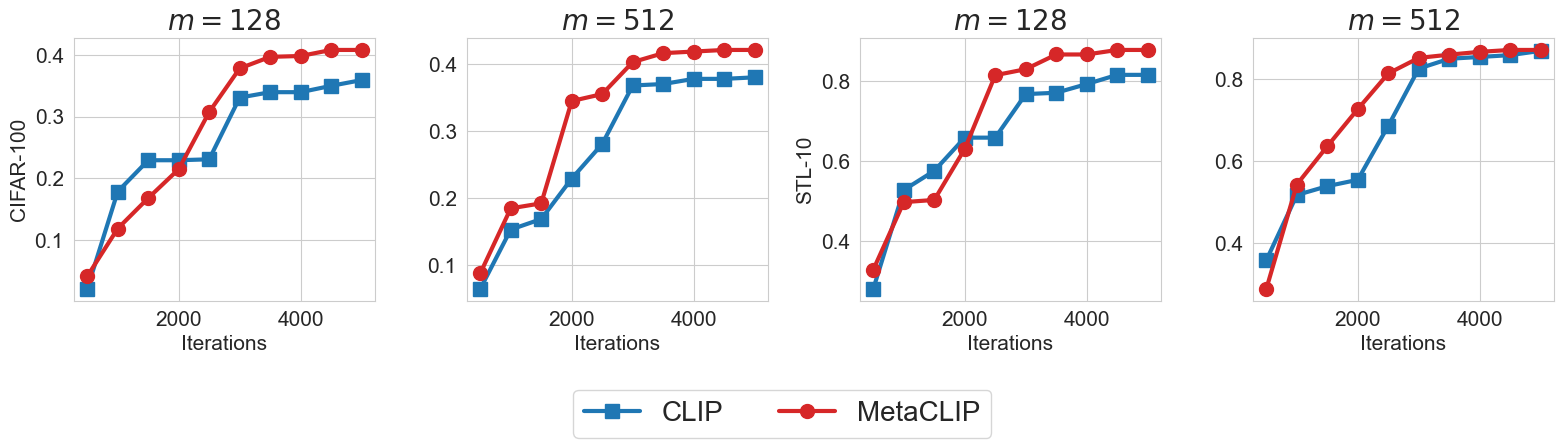

In [11]:
sns.set_style("whitegrid")

fig, axes = plt.subplots(1, 4, figsize=(16, 4),sharex=True)

embed_str = "separate"
datasets = ["cifar/", "CIFAR-100", "STL-10"]
datasets = ["cifar100", "stl10"]
dat_names = ["CIFAR-100", "STL-10"]

for i, dataset in enumerate(datasets):
    axes[2 * i].set_ylabel(dat_names[i])
    for j, batch_str in enumerate(["_b128", ""]):
        create_ax(axes[2 * i + j], batch_str, dataset)

axes[0].set_title(r"$m = 128$")
axes[1].set_title(r"$m = 512$")
axes[2].set_title(r"$m = 128$")
axes[3].set_title(r"$m = 512$")

axes[0].set_xlabel("Iterations")
axes[1].set_xlabel("Iterations")
axes[2].set_xlabel("Iterations")
axes[3].set_xlabel("Iterations")

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles=handles, labels=labels, loc='center',
        bbox_to_anchor=(0.5, -0.08), ncol=2)

fig.tight_layout(pad=2.0)